# Step 1
## Import required packages
* os: useful package for accessing directories and files
* matplotlib.pyplot: basic python plotting package
* chem: our QSAR regression package
* pandas: data I/O 
* numpy: matrix operations
* sklearn.metrics: machine learning metrics

In [12]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import chem
import pandas as pd
import numpy as np
from sklearn import metrics

# Step 2
## Data load, transformation and simple visualization
Read the data from CSV into a Pandas DataFrame.
Convert the clearance to log_cl
Plot the histogram of log_cl

Raw data size is 2176 rows x 206 columns


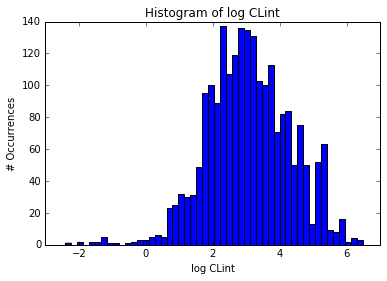

In [13]:
data = pd.read_csv(os.path.join(os.getcwd(),'data','t0.5_washed_descriptors.csv'))
print('Raw data size is %d rows x %d columns' % data.shape)
# Perform log transformation of CL values to be used as label values in the model
log_cl = pd.Series(np.log(data['CL (mL/min*kg)'].values),index=data['CMPD_CHEMBLID'])
# Generate histogram
h = plt.hist(log_cl,bins=50)
# Make plot look nice
plt.xlabel('log CLint')
plt.ylabel('# Occurrences')
plt.title('Histogram of log CLint')
# Display plot
plt.show()

# Step 3
## Split data into training and test set
This split is performed by simply using the first 1500 chemicals as the training set and holding out the rest as a test set.  

In [14]:
# Initialize the column index of the first molecular descriptor in the DataFrame
first_feature_index = 14
# Extract molecular descriptors, leaving out the metadata for each chemical
features = data[list(data.columns.values)[first_feature_index:]]
# Simple split for training set by using first 1500 chemicals in the dataset
train_index = 1500
# Split the dataset into training and hold-out test sets
train_features = features.iloc[:train_index]
train_labels = log_cl.iloc[:train_index]
test_features = features.iloc[train_index:]
test_labels = log_cl.iloc[train_index:]


# Step 4
## Reduce feature set
Reduce the feature set using RF feature importances and the AIC metric.  

In [16]:
# Package training data as a dictionary to be passed to the reducer object
train_data_dict = {'X': np.array(train_features),
                   'y': np.array(train_labels)}
# Initialize our feature reducer.  The verbosity will show results while the reducer is running
reducer = chem.preprocess.Reducer(verbose=2)
# Fit the reducer with the training data
reducer.fit(train_data_dict)
# Display the chosen features
print('Best number of features:', len(reducer.featureList))
print('Reduced features:\n', features.columns.values[reducer.featureList])

1  features being tested
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
AIC: 8021.55293507
BIC:  8024.86615545
RMSE:  1.44763697119 

5  features being tested
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
AIC: 7579.25645856
BIC:  7603.8225605
RMSE:  1.2458695583 

10  features being tested
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min

# Step 5
## Create and evaluate the model
Model created using reduced feature set and evaluated with RMSE

In [17]:
# Initialize modeler
modeler = chem.Modeler()
# Reduce training and test feature sets based on reducer results
reduced_train_features = train_features[features.columns.values[reducer.featureList]]
reduced_test_features = test_features[features.columns.values[reducer.featureList]]
# Fit model with reduced feature sets
modeler.fit(reduced_train_features, train_labels)
# Make predictions on hold-out test set
predictions = modeler.predict(reduced_test_features)
# Display results
print('RMSE: ',np.sqrt(metrics.mean_squared_error(predictions, test_labels)))

RMSE:  1.17923650823
